<a href="https://colab.research.google.com/github/MareshalJO/BIM-LCA-Analysis/blob/main/Sobol_Variance_based_sensitivity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from SALib import ProblemSpec
from SALib.analyze import sobol
import logging
import os
from tqdm import tqdm

# --------------------------
# Configuration & Setup
# --------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("sobol_analysis.log"), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Project constants
GFA = 9750.03  # m²
N_SAMPLES = 10000  # Number of samples for Sobol (recommended: 10,000+)
RANDOM_SEED = 42
OUTPUT_DIR = "sobol_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define Sobol problem (parameters to test)
# Format: [parameter name, lower bound, upper bound]
# Bounds = base value ± 20% (standard for sensitivity analysis)
PROBLEM_DEFINITION = {
    "num_vars": 8,
    "names": [
        "concrete_mass", "concrete_ef",
        "steel_mass", "steel_ef",
        "masonry_mass", "masonry_ef",
        "electricity_ef", "diesel_ef"
    ],
    "bounds": [
        [17024000 * 0.8, 17024000 * 1.2],  # Concrete mass (±20%)
        [0.28 * 0.8, 0.28 * 1.2],          # Concrete EF (±20%)
        [622000 * 0.8, 622000 * 1.2],      # Steel mass (±20%)
        [1.80 * 0.8, 1.80 * 1.2],          # Steel EF (±20%)
        [13000 * 0.8, 13000 * 1.2],        # Masonry mass (±20%)
        [0.65 * 0.8, 0.65 * 1.2],          # Masonry EF (±20%)
        [0.525 * 0.8, 0.525 * 1.2],        # Electricity EF (±20%)
        [3.21 * 0.8, 3.21 * 1.2]           # Diesel EF (±20%)
    ]
}

# --------------------------
# Core Functions
# --------------------------
def gwp_objective_function(params):
    """
    Objective function for Sobol analysis: calculate GWP per m²
    Input: params (array of parameter values)
    Output: GWP per m² (kgCO2e/m²)
    """
    # Unpack parameters
    concrete_mass, concrete_ef, steel_mass, steel_ef, masonry_mass, masonry_ef, elec_ef, diesel_ef = params

    # Calculate GWP for each component (kgCO2e)
    concrete_gwp = concrete_mass * concrete_ef
    steel_gwp = steel_mass * steel_ef
    masonry_gwp = masonry_mass * masonry_ef
    insulation_gwp = 76000 * 1.10  # Fixed (low variance)
    electricity_gwp = 305278.57 * elec_ef  # Fixed kWh, variable EF
    diesel_gwp = 57265.06 * diesel_ef      # Fixed L, variable EF

    # Total GWP
    total_gwp_kg = concrete_gwp + steel_gwp + masonry_gwp + insulation_gwp + electricity_gwp + diesel_gwp
    gwp_per_m2 = total_gwp_kg / GFA

    return gwp_per_m2

def run_sobol_analysis():
    """Run Sobol sensitivity analysis (total-order indices)"""
    logger.info(f"Starting Sobol analysis with {N_SAMPLES} samples (seed={RANDOM_SEED})")

    # Initialize problem spec
    sp = ProblemSpec(PROBLEM_DEFINITION)
    sp.sample_sobol(N_SAMPLES, seed=RANDOM_SEED)

    # Evaluate objective function (GWP) for all samples
    logger.info("Evaluating GWP for Sobol samples (this may take a few minutes)")
    # Manual evaluation loop because SALib's evaluate method is passing kwargs directly to gwp_objective_function
    Y = np.array([gwp_objective_function(sample) for sample in tqdm(sp.samples, desc="Evaluating GWP")])
    sp.results = Y

    # Analyze results (total-order indices)
    logger.info("Calculating Sobol total-order indices")
    si = sobol.analyze(PROBLEM_DEFINITION, sp.results, calc_second_order=False)  # Skip 2nd order for speed

    # Extract key results (total-order indices + confidence intervals)
    sobol_results = {
        "parameter": PROBLEM_DEFINITION["names"],
        "S1": si["S1"],  # First-order index (direct effect)
        "ST": si["ST"],  # Total-order index (direct + indirect effects)
        "ST_conf": si["ST_conf"]  # 95% confidence interval for total-order
    }

    # Convert to DataFrame
    sobol_df = pd.DataFrame(sobol_results)
    sobol_df = sobol_df.sort_values(by="ST", ascending=False)  # Sort by total impact

    # Save results
    sobol_df.to_csv(os.path.join(OUTPUT_DIR, "sobol_indices.csv"), index=False)
    logger.info(f"Sobol results saved: {sobol_df}")

    return sobol_df, si

def plot_sobol_results(sobol_df):
    """Plot Sobol total-order indices (paper-ready)"""
    logger.info("Generating Sobol sensitivity plots")

    # Rename parameters for readability
    param_rename = {
        "concrete_mass": "Concrete Mass",
        "concrete_ef": "Concrete EF",
        "steel_mass": "Steel Mass",
        "steel_ef": "Steel EF",
        "masonry_mass": "Masonry Mass",
        "masonry_ef": "Masonry EF",
        "electricity_ef": "Electricity EF",
        "diesel_ef": "Diesel EF"
    }
    sobol_df["parameter_label"] = sobol_df["parameter"].map(param_rename)

    # Plot total-order indices
    plt.figure(figsize=(12, 8))
    sns.barplot(x="ST", y="parameter_label", data=sobol_df, color="#2E86AB")

    # Add error bars (95% CI)
    plt.errorbar(
        x=sobol_df["ST"],
        y=sobol_df["parameter_label"],
        xerr=sobol_df["ST_conf"],
        fmt="none",
        color="black",
        capsize=5
    )

    # Add value labels
    for i, row in sobol_df.iterrows():
        plt.text(row["ST"] + 0.01, i, f"{row['ST']:.2f}", va="center")

    plt.xlabel("Sobol Total-Order Index (ST)")
    plt.ylabel("Parameter")
    plt.title("Sobol Sensitivity Analysis: Key Drivers of GWP Variance")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "sobol_total_order_indices.png"), dpi=300, bbox_inches="tight")
    plt.close()

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    # Run Sobol analysis
    sobol_df, si = run_sobol_analysis()

    # Plot results
    plot_sobol_results(sobol_df)

    # Log top drivers
    top_drivers = sobol_df.head(3)["parameter_label"].tolist()
    logger.info(f"Top 3 GWP drivers: {top_drivers}")
    logger.info("Sobol analysis completed successfully!")

/usr/local/lib/python3.12/dist-packages/SALib/sample/sobol.py:136: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  base_sequence = qrng.random(N)
Evaluating GWP: 100%|██████████| 180000/180000 [00:00<00:00, 331895.68it/s]


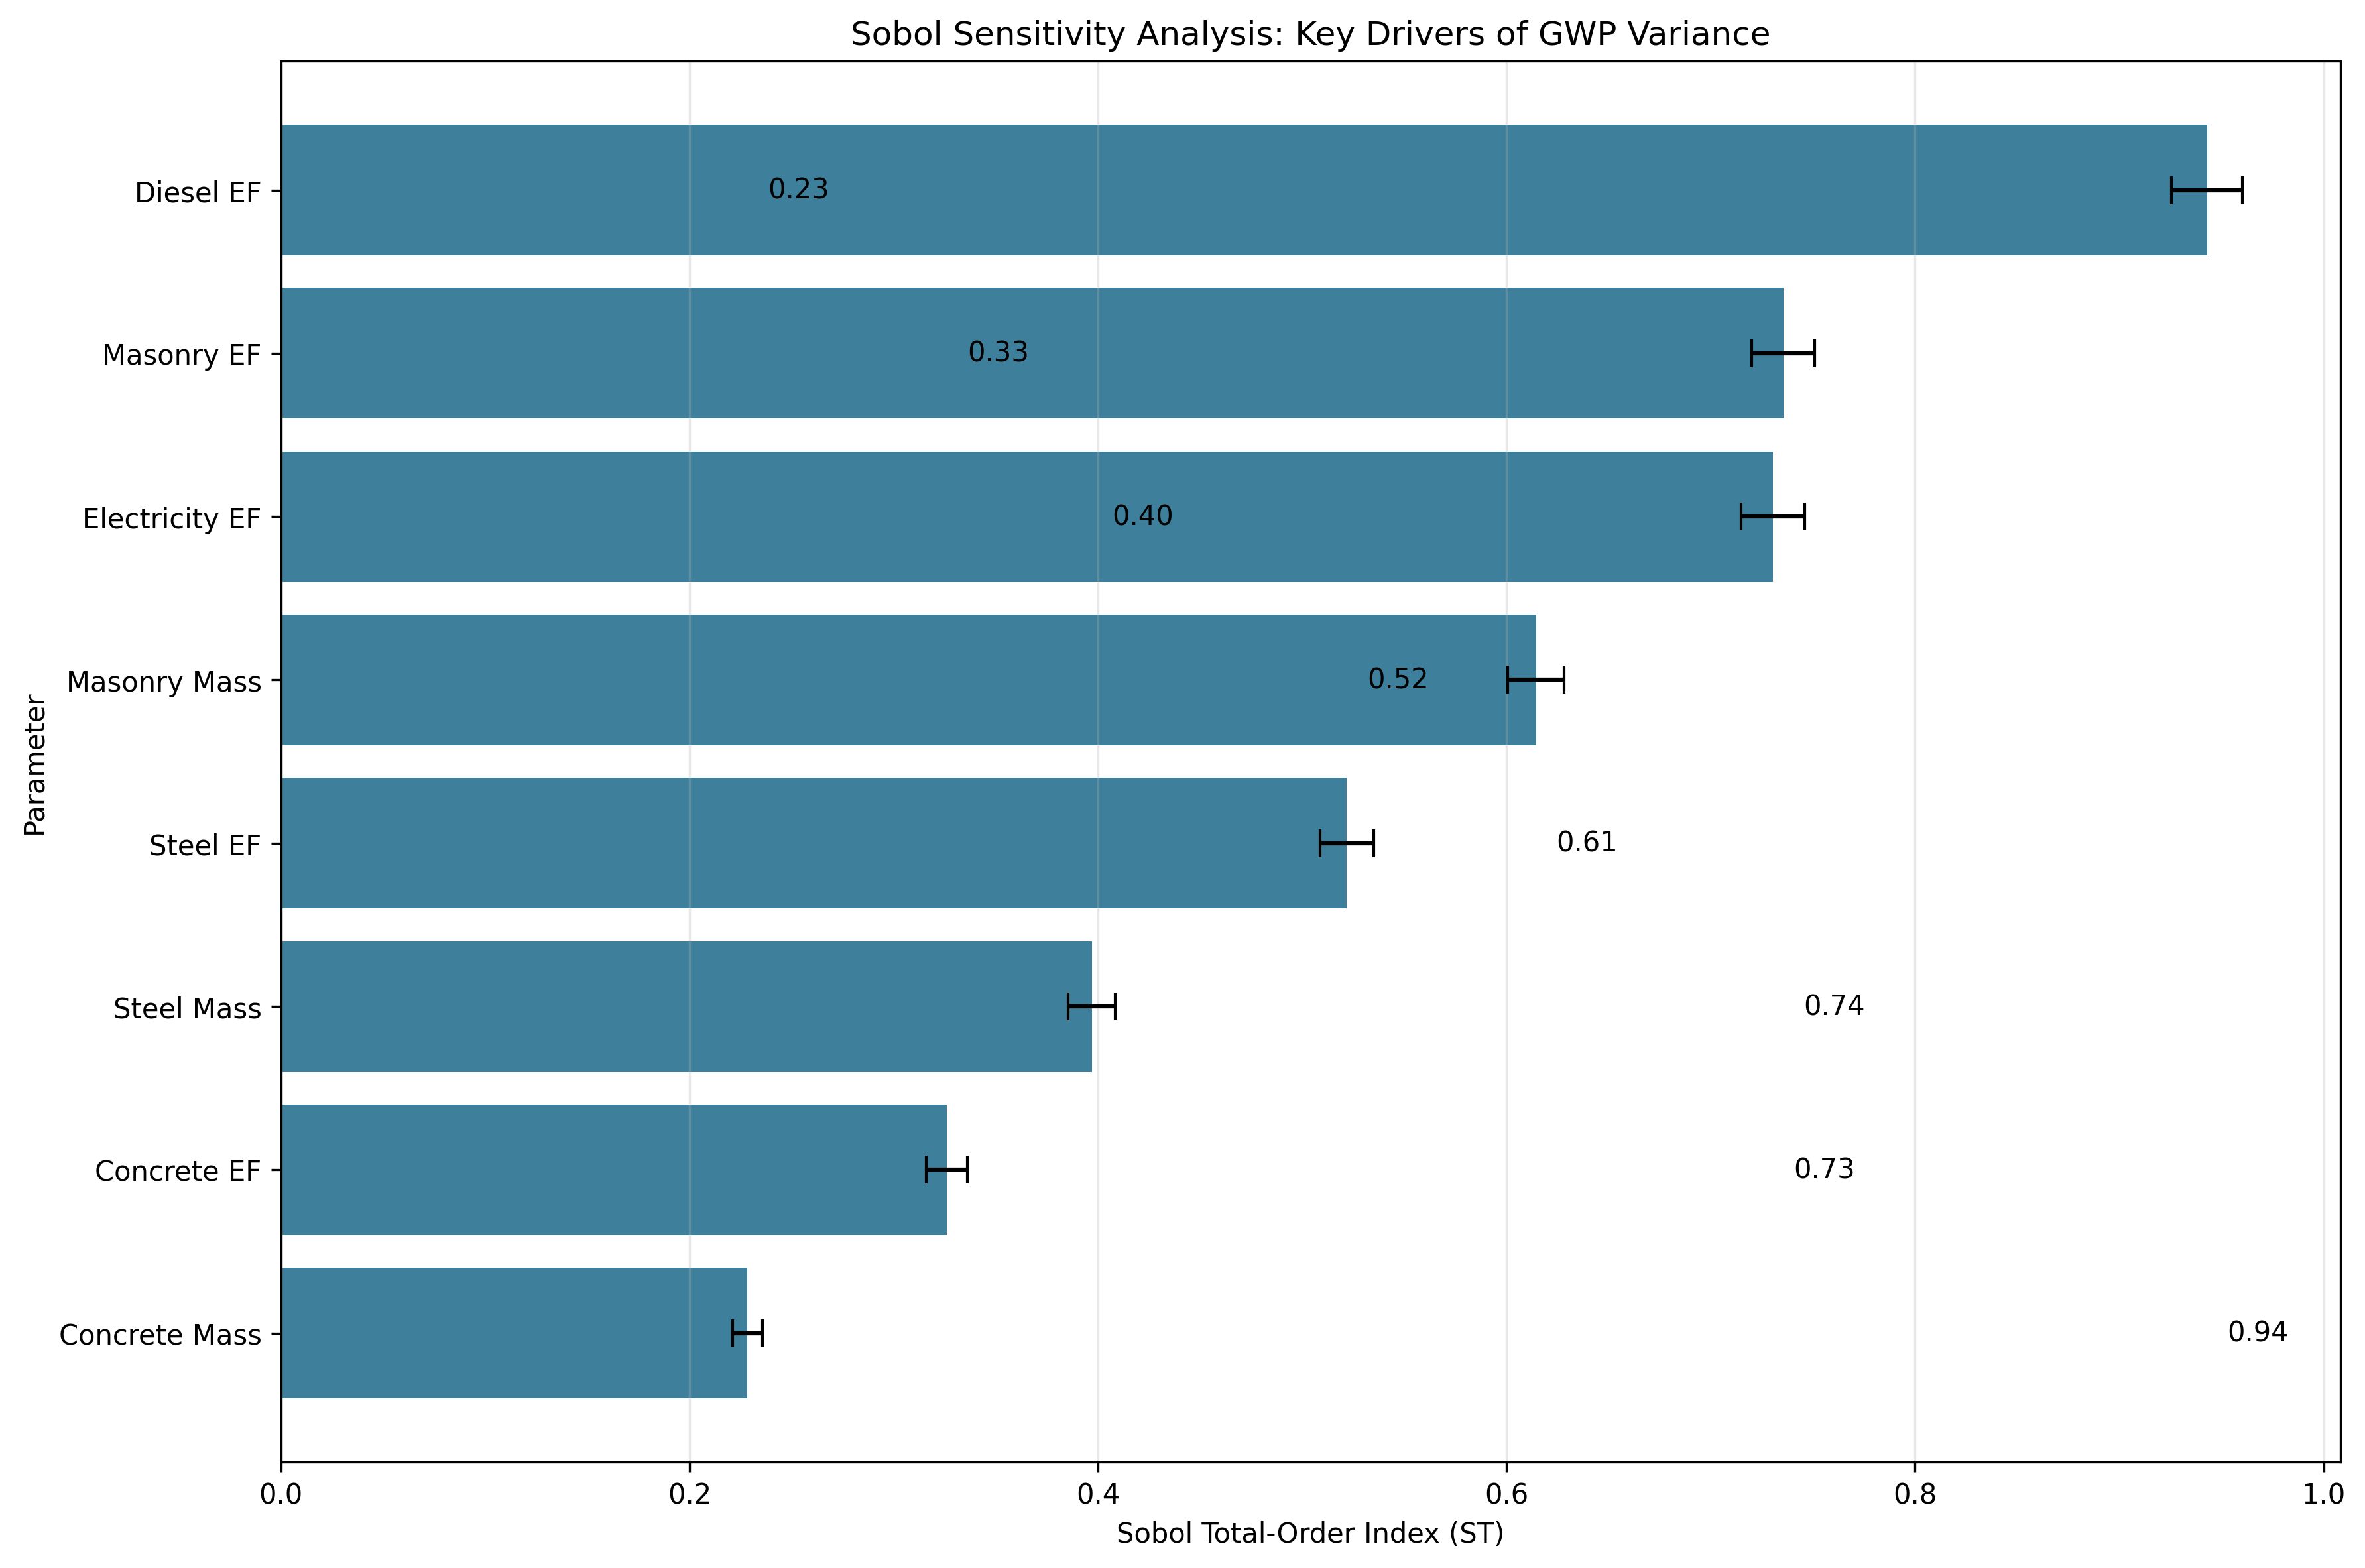

In [9]:
from IPython.display import Image
import os

OUTPUT_DIR = "sobol_results"
plot_path = os.path.join(OUTPUT_DIR, "sobol_total_order_indices.png")
display(Image(filename=plot_path))

In [2]:
pip install SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 34.4 MB/s eta 0:00:00
